In [1]:
import numpy as np
import pandas as pd
import torch 
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
# Open here your pickle files both the SUSY and the ttbar 

sig_df  = pd.read_pickle('SUSY_Mstop_175.pkl')
bkg_df  = pd.read_pickle('ttbar.pkl')

# Access the different columns of the data frame, say pt,eta etc ..
bkg_df

,L pt,Lbar pt,L eta,Lbar eta,Abs Delta Eta,Abs Delta Phi
0,68.813210,27.302094,0.783428,0.082621,0.700806,2.790541
1,53.816910,33.045055,-0.504254,0.294797,0.799050,0.797296
2,32.939449,59.064556,-0.926941,1.881812,2.808753,1.635645
3,38.570145,71.512238,0.044036,-0.361570,0.405607,1.633022
4,43.054966,61.946774,0.135901,-0.311101,0.447003,0.544630
...,...,...,...,...,...,...
701589,66.935829,86.495033,2.153407,1.034294,1.119113,1.494943
701590,63.952545,40.639206,-0.625261,-1.788905,1.163644,2.543142
701591,218.240356,41.113899,-1.833916,-0.247579,1.586337,2.576784
701592,25.682802,34.545418,-1.336810,1.292909,2.629719,2.973686


In [3]:
# Normalize the inputs by computing the z score
# z score = x - mean / std_dev

# To obtain the mean and std dev use :
# mean      = df.mean()
# std       = df.std() 
# and then 
# df_normed = df - mean /std 

# this operation acts on all rows at once, so no loop is needed
# make sure you don't overwrite the original dataframe 
# Repeat for both SUSY (signal) and ttbar(backgroung) dataframe

bkg_df   = bkg_df[1:len(sig_df)]

sig_mean = sig_df.mean()
sig_std  = sig_df.std()

bkg_mean = bkg_df.mean()
bkg_std  = bkg_df.std()

sig_df   = (sig_df - bkg_mean)/ sig_std
bkg_df   = (bkg_df - bkg_mean)/ bkg_std

signal   = sig_df.values
bkg      = bkg_df.values

## Concatenate (join together) the 2 dataframes (sig_df_normed and bkg_df_normed) call this dataframe x
x        = np.concatenate((signal,bkg))

(array([10067.,  8507.,  5967.,  3678.,  1787.,   904.,   336.,   111.,
           31.,    14.]),
 array([-1.55514499, -0.88574594, -0.21634689,  0.45305216,  1.12245121,
         1.79185026,  2.46124931,  3.13064836,  3.80004741,  4.46944645,
         5.1388455 ]),
 <a list of 1 Patch objects>)

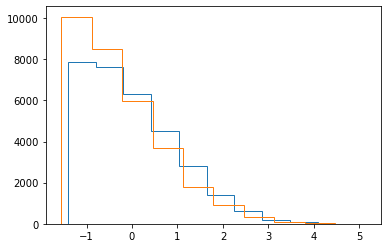

In [65]:
plt.hist(bkg_df['Abs Delta Eta'], histtype = 'step')
plt.hist(sig_df['Abs Delta Eta'], histtype = 'step')

In [4]:
# Create a series of 1's as a label for signal 
# and 0's as a label for the background
# Code provided, just uncomment

# sig_label = np.ones(len(sig_df_normed))
# bkg_label = np.zeros(len(bkg_df_normed))

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

# Concatenate (join together) the 2 dataframes (sig_label and bkg_label) call this dataframe y
y         = np.concatenate((sig_label,bkg_label))

In [16]:
'''
# Naively you may assume 

# Cut x in two parts in a ratio 3:1, call one of them x_train and one x_test
tf_length = int(0.75 * len(data))

data_train = data[1: tf_length]
data_test  = data[tf_length: len(data)]

# Cut y in two parts in a ratio 3:1, call one of them y_train and one y_test
label_train = label[1: tf_length]
label_test  = label[tf_length : len(label)]

# These are the training and testing datasets respectively
'''

In [64]:
tf_length = int(0.75 * len(x))
label_train = y[1: tf_length]

len(label_train[label_train == 0])

15700

In [31]:
#from sklearn.model_selection import train_test_split
#x_train, x_test = train_test_split(data, test_size=0.25)
#y_train, y_test = train_test_split(label, test_size=0.25)

In [9]:
# Cut x in two parts in a ratio 3:1, call one of them x_train and one x_test

from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(x, test_size=0.25)
x_train = torch.from_numpy(x_train)
x_test  = torch.from_numpy(x_test)

# Cut y in two parts in a ratio 3:1, call one of them y_train and one y_test
y_traindf, y_testdf = train_test_split(y, test_size=0.25)
y_train = torch.from_numpy(y_traindf)
y_test  = torch.from_numpy(y_testdf)
print(type(y_train))
print(len(y_train))
print(len(y_test))

<class 'torch.Tensor'>
47102
15701


In [10]:
# Now shuffle the dataframes
# Code provided, just uncomment
idx = np.random.permutation(len(x_train))

x_train = x_train[idx]
y_train = y_train[idx]

In [15]:
y_train=y_train.type(torch.LongTensor)

In [24]:
# Define your model
# Recall from your Spiral Classifier notebook :

D = 6
C = 2
H = 10

learning_rate = 1e-3
lambda_l2     = 1e-5
nepochs       = 150

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C),
)

In [25]:
x_train.values

<function Tensor.values>

In [27]:
# nn package also has different loss functions.
# We use cross entropy loss for our classification task

loss_function = torch.nn.CrossEntropyLoss()

# We use the optim package to apply 
# Stochastic Gradient Descent for our parameter updates

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(nepochs):
    
    # This one line represents the forward pass
    y_pred = model(x_train.float())
    
    # Compute the loss and accuracy    
    loss   = loss_function(y_pred, y_train)
    
    # The predicted class is the one with maximum probability 
    # associated to it, hence we find the row wise maximas
    
    score, predicted = torch.max(y_pred,1)
    
    # Length of correct labels divided by total length is accuracy
    acc    = (y_train == predicted).sum().float() / len(y_train)
    
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    
    #display.clear_output(wait=True)
    
    # Zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update the weights
    optimizer.step()

[EPOCH]: 0, [LOSS]: 0.705940, [ACCURACY]: 0.500
[EPOCH]: 1, [LOSS]: 0.705340, [ACCURACY]: 0.500
[EPOCH]: 2, [LOSS]: 0.704744, [ACCURACY]: 0.500
[EPOCH]: 3, [LOSS]: 0.704183, [ACCURACY]: 0.501
[EPOCH]: 4, [LOSS]: 0.703635, [ACCURACY]: 0.502
[EPOCH]: 5, [LOSS]: 0.703121, [ACCURACY]: 0.501
[EPOCH]: 6, [LOSS]: 0.702618, [ACCURACY]: 0.502
[EPOCH]: 7, [LOSS]: 0.702153, [ACCURACY]: 0.502
[EPOCH]: 8, [LOSS]: 0.701698, [ACCURACY]: 0.501
[EPOCH]: 9, [LOSS]: 0.701276, [ACCURACY]: 0.501
[EPOCH]: 10, [LOSS]: 0.700868, [ACCURACY]: 0.501
[EPOCH]: 11, [LOSS]: 0.700496, [ACCURACY]: 0.501
[EPOCH]: 12, [LOSS]: 0.700130, [ACCURACY]: 0.501
[EPOCH]: 13, [LOSS]: 0.699805, [ACCURACY]: 0.501
[EPOCH]: 14, [LOSS]: 0.699486, [ACCURACY]: 0.501
[EPOCH]: 15, [LOSS]: 0.699200, [ACCURACY]: 0.501
[EPOCH]: 16, [LOSS]: 0.698927, [ACCURACY]: 0.501
[EPOCH]: 17, [LOSS]: 0.698671, [ACCURACY]: 0.501
[EPOCH]: 18, [LOSS]: 0.698432, [ACCURACY]: 0.501
[EPOCH]: 19, [LOSS]: 0.698215, [ACCURACY]: 0.501
[EPOCH]: 20, [LOSS]: 0.698008,

In [35]:
# Check your accuracy and verify it on the test data
zero_pred = model(x_test.float()) [:,0]
one_pred  = model(x_test.float()) [:,1]

(array([3.000e+00, 5.000e+01, 3.126e+03, 1.031e+04, 2.006e+03, 1.840e+02,
        1.800e+01, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([-0.6931465 , -0.4684679 , -0.24378927, -0.01911064,  0.20556799,
         0.43024662,  0.6549252 ,  0.87960386,  1.1042825 ,  1.3289611 ,
         1.5536398 ], dtype=float32),
 <a list of 1 Patch objects>)

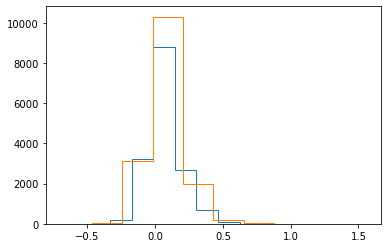

In [44]:
plt.hist(zero_pred.detach().numpy(), histtype = 'step' )
plt.hist(one_pred.detach().numpy(), histtype = 'step' )

In [57]:
torch.from_numpy(sig_df.values)

tensor([[-1.0389e+00, -9.3967e-02, -1.7380e-01,  5.8254e-02, -1.1621e+00,
         -8.4742e-01],
        [-1.0365e+00, -4.7374e-01, -2.0042e+00, -2.1719e+00, -1.2828e+00,
         -1.4004e+00],
        [-9.6299e-01,  6.8967e-01,  3.7047e-01,  5.7046e-01, -1.2139e+00,
         -6.5308e-02],
        ...,
        [-5.4390e-01,  3.7149e-01, -5.3353e-01, -3.2982e-01, -1.2098e+00,
          2.0882e-01],
        [-4.7847e-01,  4.8880e-01, -3.5708e-01,  1.3515e+00,  1.2795e+00,
         -1.9509e+00],
        [-9.4952e-01,  3.3045e-03,  2.7958e+00, -6.0449e-01,  4.0523e+00,
          7.7609e-01]], dtype=torch.float64)